Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [9]:
from __future__ import print_function
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [10]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [11]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))


Data size 17005207


In [12]:
#Print first 10 words from file
words[0:10]

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against']

Build the dictionary and replace rare words with UNK token.

In [13]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  #ANKITNOTE: Find highest freq 50k words
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  #print(count)
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  #ANKITNOTE: Give ranks from hightest to lowest 50k frequency - UNK is 0
  #print(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  #print(data)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])

#ANKITNOTE- Data is basically the input stream of text converted into numerics. Example -
# If the sentence was - Tommy is my best friend
# AND the ranks(frequency) for each word were (picked at random) Tommy - 32, is - 10, my - 11, friend - 99
#data stream would look like - 32 10 11 44 99

print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


In [14]:
#ANKITNOTE - the above function build dataset returns 
#- data which is a list of ranks (0s for >50k ranks) -- numerial translation of the words
#- count which is top 50k freq words
#- dictionary - 50k words and ranks
#- reverse dictionary - 50k ranks and words
#First word is anarchism - data has numerical representation of the text
dictionary['anarchism']

5234

Function to generate a training batch for the skip-gram model.

In [15]:
data_index = 0

#Skip window - is distance of the context word wrt target in 1 direction. 
#num_skips - is the number of such pairs you want to generate
#Example - Tommy is my best friend
# skip_window = 1
# num_skips = 2
#2 pairs are generated - 1. (my,is) 2. (my,best)

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer - This is the target word
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'as', 'term', 'a', 'of']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'anarchism', 'term', 'originated', 'as', 'of', 'originated', 'term']


Train a skip-gram model.

In [16]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keepdims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [17]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.861835
Nearest to many: reparation, myriad, hunyadi, whois, adam, mitosis, khanate, andre,
Nearest to been: servant, superboy, iast, penal, rudder, ther, longhair, torus,
Nearest to can: dendritic, makeover, geneva, lodgings, willing, pounds, ubu, ebooks,
Nearest to to: adsl, clitoral, tuberculosis, intend, gleason, kanembu, neuromancer, annoy,
Nearest to also: virginity, interjections, larissa, glowing, pseudoscientific, derrida, montana, intuitionist,
Nearest to or: fragmented, wisdom, grammy, collided, croydon, upcoming, itinerary, avengers,
Nearest to all: epithet, gbit, heineken, externalism, dashboard, enlisting, macphail, etienne,
Nearest to while: wished, eugenie, temporally, specializes, vardar, zoran, watterson, scaled,
Nearest to its: accept, igor, esq, exposes, separate, passos, iq, mildred,
Nearest to in: vicki, rupture, contractor, leucine, shimon, provenance, ellipses, berets,
Nearest to most: realplayer, sophisticated, adventures, d

Average loss at step 52000: 3.436815
Average loss at step 54000: 3.431923
Average loss at step 56000: 3.440430
Average loss at step 58000: 3.401315
Average loss at step 60000: 3.392626
Nearest to many: some, several, various, these, both, other, most, all,
Nearest to been: become, be, was, were, trusteeship, had, already, never,
Nearest to can: may, could, will, must, would, might, cannot, should,
Nearest to to: parsers, would, must, tuberculosis, adsl, not, barons, will,
Nearest to also: now, still, often, sometimes, never, typically, below, who,
Nearest to or: and, than, tabs, lyre, non, dimensional, but, frau,
Nearest to all: both, these, proper, some, any, those, many, landholders,
Nearest to while: although, when, though, before, if, however, after, where,
Nearest to its: their, his, the, her, shou, pitting, your, uplink,
Nearest to in: within, during, on, since, of, between, from, at,
Nearest to most: more, many, some, tunku, coding, delusion, use, armenian,
Nearest to use: start

In [18]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

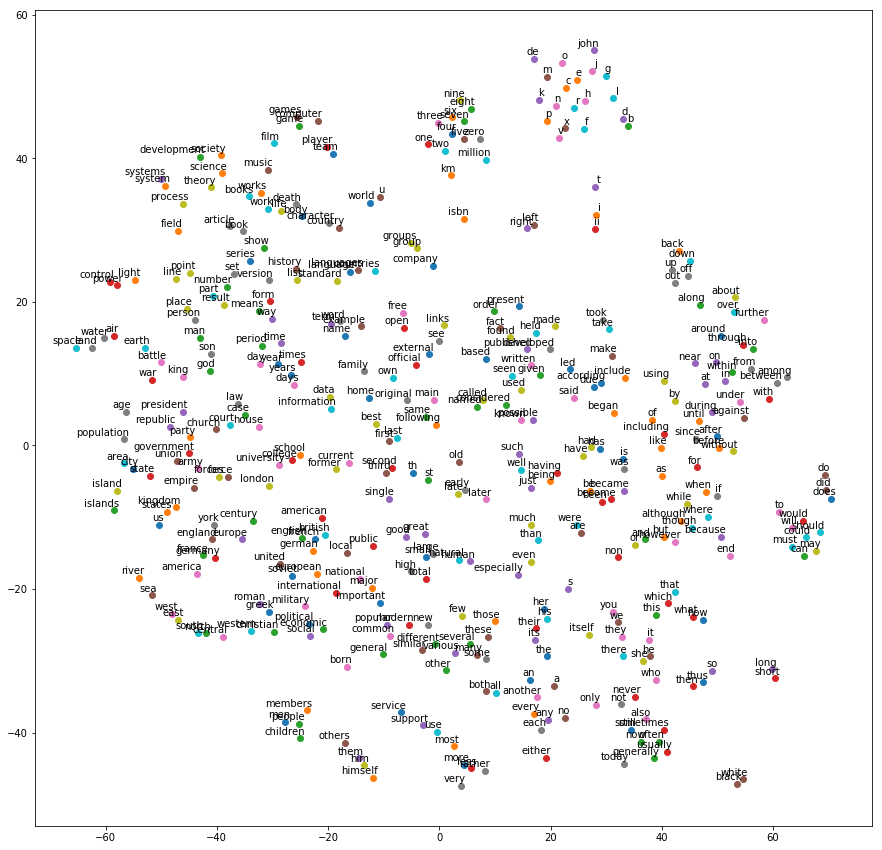

In [19]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [20]:
data_index = 0

def generate_batch(batch_size, skip_window):
    # skip window is the amount of words we're looking at from each side of a given word
    # creates a single batch
    global data_index

    span = 2 * skip_window + 1 # [ skip_window target skip_window ]

    batch = np.ndarray(shape=(batch_size,span-1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    # e.g if skip_window = 2 then span = 5
    # span is the length of the whole frame we are considering for a single word (left + word + right)
    # skip_window is the length of one side

    # queue which add and pop at the end
    buffer = collections.deque(maxlen=span)

    #get words starting from index 0 to span from the numeric type converted text
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    # num_skips => # of times we select a random word within the span?
    # batch_size (8) and num_skips (2) (4 times)
    # batch_size (8) and num_skips (1) (8 times)
    for i in range(batch_size):
    #for each batch
    
        target = skip_window  # target label at the center of the buffer
        target_to_avoid = [ skip_window ] # we only need to know the words around a given word, not the word itself

        # do this num_skips (2 times)
        # do this (1 time)

        # add selected target to avoid_list for next time
        col_idx = 0
        for j in range(span):
            if j==span//2:
                continue
            # e.g. i=0, j=0 => 0; i=0,j=1 => 1; i=1,j=0 => 2
            batch[i,col_idx] = buffer[j] # [skip_window] => middle element
            col_idx += 1
            
        labels[i, 0] = buffer[target]

        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)

    assert batch.shape[0]==batch_size and batch.shape[1]== span-1
    return batch, labels



for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    
    print('    batch:', [[reverse_dictionary[bii] for bii in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])


with num_skips = 2 and skip_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and skip_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [21]:
num_steps = 100001

if __name__ == '__main__':
    batch_size = 128
    embedding_size = 128 # Dimension of the embedding vector.
    skip_window = 1 # How many words to consider left and right.
    num_skips = 2 # How many times to reuse an input to generate a label.
    # We pick a random validation set to sample nearest neighbors. here we limit the
    # validation samples to the words that have a low numeric ID, which by
    # construction are also the most frequent.
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100 # Only pick dev samples in the head of the distribution.
    # pick 16 samples from 100
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,random.sample(range(1000,1000+valid_window), valid_size//2))
    num_sampled = 64 # Number of negative examples to sample.

    graph = tf.Graph()

    with graph.as_default(), tf.device('/cpu:0'):

        # Input data.
        train_dataset = tf.placeholder(tf.int32, shape=[batch_size,2*skip_window])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
        valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

        # Variables.
        # embedding, vector for each word in the vocabulary
        embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        softmax_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
        softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

        # Averaging embeddings accross the full context into a single embedding layer
        context_embeddings = []
        for i in range(2*skip_window):
            context_embeddings.append(tf.nn.embedding_lookup(embeddings, train_dataset[:,i]))
            
        avg_embed =  tf.reduce_mean(tf.stack(axis=0,values=context_embeddings),0,keep_dims=False)

        # Compute the softmax loss, using a sample of the negative labels each time.
        # inputs are embeddings of the train words
        # with this loss we optimize weights, biases, embeddings

        loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=avg_embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

        # Optimizer.
        optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

        # Compute the similarity between minibatch examples and all embeddings.
        # We use the cosine distance:
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm
        valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
        similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

    with tf.Session(graph=graph) as session:
        tf.global_variables_initializer().run()
        print('Initialized')
        average_loss = 0
        for step in range(num_steps):
            batch_data, batch_labels = generate_batch(batch_size, skip_window)
            feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
            _, l = session.run([optimizer, loss], feed_dict=feed_dict)
            average_loss += l
            if step % 2000 == 0:
                if step > 0:
                    average_loss = average_loss / 2000
                    # The average loss is an estimate of the loss over the last 2000 batches.
                print('Average loss at step %d: %f' % (step, average_loss))
                average_loss = 0
            if step % 10000 == 0:
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = reverse_dictionary[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = reverse_dictionary[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
        final_embeddings = normalized_embeddings.eval()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Initialized
Average loss at step 0: 7.490232
Nearest to their: joyce, rammed, walker, ymca, ruptured, swamp, pagan, cautions,
Nearest to he: smokey, catchers, examines, citigroup, hyperbola, stratigraphy, inerrancy, gpo,
Nearest to may: extensionality, meine, seattle, wafers, carcinoma, tuba, bonham, proconsular,
Nearest to in: brac, sumatra, soli, knapsack, xn, custard, computed, oversized,
Nearest to which: ultra, peace, rodney, purpose, phanerozoic, rise, employees, bare,
Nearest to s: anc, remarking, sectors, evaluations, embryos, lindo, culture, integrator,
Nearest to his: divination, pigeons, gott, earliest, masturbating, rings, himachal, metaphors,
Nearest to than: duquette, hagen, talented, religionfacts, xiii, louisiana, multics, christian,
Nearest to mean: tonal, sooner, conclusive, goofy, strikes, euphemisms, tsh, eldr,
Nearest to 

Average loss at step 50000: 2.849943
Nearest to their: its, his, her, your, our, the, my, supersede,
Nearest to he: she, it, they, eventually, who, there, officially, uploads,
Nearest to may: can, might, should, must, will, could, would, cannot,
Nearest to in: during, within, at, near, throughout, of, on, clinch,
Nearest to which: that, this, what, also, who, these, generally, methodist,
Nearest to s: asch, maris, cg, his, integrator, zuid, desktop, your,
Nearest to his: her, their, its, my, your, juntas, our, the,
Nearest to than: or, awoke, duquette, much, slightly, freedmen, crossed, sponsor,
Nearest to mean: contain, tonal, rounded, apply, strongholds, prosody, conclusive, make,
Nearest to joseph: punishments, acid, louis, demolished, pynchon, charpentier, aardwolf, martin,
Nearest to placed: shipwreck, released, able, presented, voris, missed, marble, found,
Nearest to police: roswell, clara, ftl, care, salisbury, jubilees, independant, certifications,
Nearest to construction: dev

In [22]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

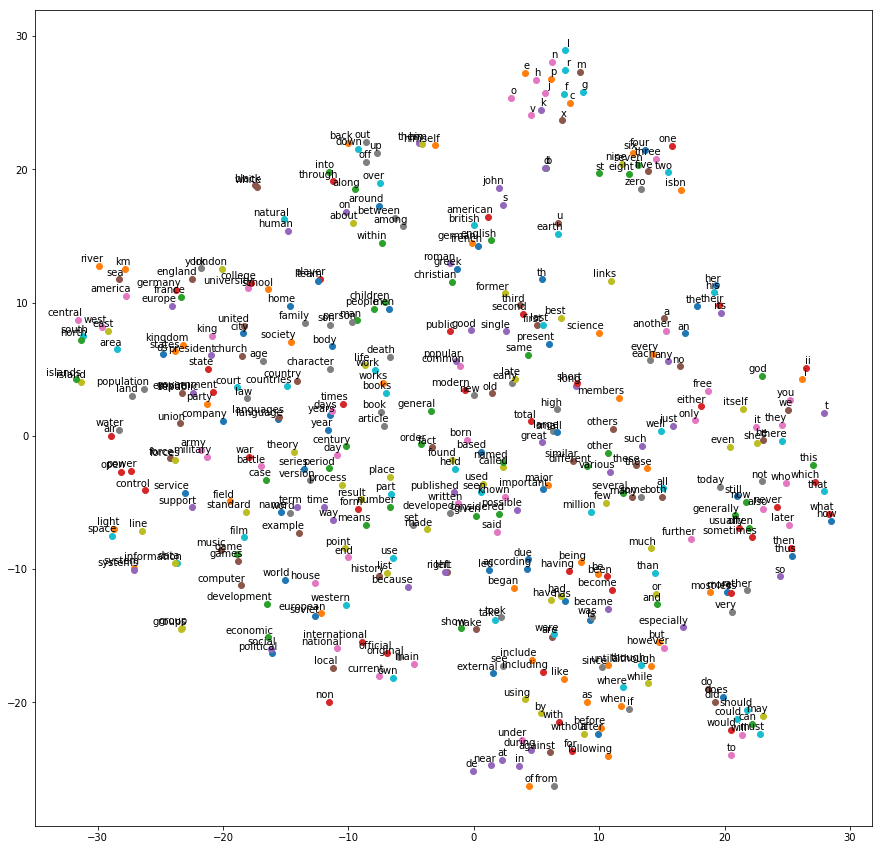

In [23]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)
